# Knapsack

Problema: Dada uma mochila com uma capacidade máxima CAP, devemos colocar N objetos nela consideram
seu valor V e seu P, dado que não ultrapassemos CAP e maximizemos o valor total dos objetos colocados na mochila.

Podemos resolver esse problema por meio de um algoritmo com N genes, variando entre 0 e 1, onde 0 representa um objeto
não colocado e 1 representa um objeto colocado na mochila. Para calcularmos o fitness de um indivíduo, usamos as seguinte fórmulas:


$V(x) = \sum_{i=1}^{N}= v_ix_i$

$P(x) = \sum_{i=1}^{N}= w_ix_i$

$Pen(x) = 0$, se x é invalida

$Pen(x) = pP(x)$, caso contrario

$p = max \frac{v_i}{w_i}$

$f(x) = V(x) - Pen(x)$

Os mecanismos utilizados para a solução foram os seguintes: Selecionar N pais utilizando a seleção de roleta,
cruzar com 1 ponto de corte com probabilidade > 0.6, seguido de Bit Flip com probabilidade entre 0.02 e 0.1 e sobreviventes
geracionais, com todos os filhos sendo substituídos. Também, antes de selecionar os país, descartamos os piores fitness.
A condição de parada é tal que, após 12 gerações em que o fitness não muda e a Capacidade é menor que o máximo, chegamos a resposta desejada.

## Solução

In [45]:
import warnings
from random import randint, sample, uniform
import matplotlib.pyplot as plt

import numpy as np
from matplotlib import MatplotlibDeprecationWarning



MAX_CAPACITY = 35
objs = np.array([
    [10, 5],
    [18, 8],
    [12, 7],
    [14, 6],
    [13, 9],
    [11, 5],
    [8, 4],
    [6, 3]
]
)


class KnapsackProblem:
    def __init__(self, obj, capacity, num_population, max_iters=10000, max_gen_to_converge=10, penalty=1):
        self.num_population = num_population
        self.max_iters = max_iters
        self.max_gen_to_converge = max_gen_to_converge
        self.obj = obj
        self.capacity = capacity
        self.penalty = penalty
        self._gens = []

    @property
    def data_per_gen(self):
        return np.array(self._gens)

    def solve(self, verbose=False, drop_worsts_proportion=0.1):
        num_population = self.num_population
        max_iters = self.max_iters
        population = np.array([KnapsackProblem.init_items() for _ in range(num_population)])
        max_gen_to_converge = self.max_gen_to_converge
        last_max_fit = 0
        hit = 0

        for i in range(max_iters):
            fitness_per_being = np.array([KnapsackProblem.fitness_function(self.obj, p, self.penalty) for p in population])
            index = np.argmax(fitness_per_being)

            if verbose:
                print(f"Generation {i}")
                print(f"Better Fitness {fitness_per_being[index]}")
                print(f"Better Being: {population[index]}")
                print(f"Current Capacity: {KnapsackProblem.current_cap(self.obj, population[index])}")
                print(f"Current Value: {KnapsackProblem.value_in_bag(self.obj, population[index])}\n")

            if hit >= max_gen_to_converge:
                break
            hit = KnapsackProblem.count_hits(fitness_per_being, hit, index, last_max_fit, population, verbose, self.obj)
            # Save data for analyse
            self._gens.append([i, max(fitness_per_being), np.mean(fitness_per_being)])

            last_max_fit = fitness_per_being[index]

            fitness_per_being, population = KnapsackProblem.drop_worst_fitness(
                drop_worsts_proportion,
                fitness_per_being,
                population
            )

            selected_parents = KnapsackProblem.fitness_roulette_selector(num_population, population, fitness_per_being)
            childrens = KnapsackProblem.gen_children(selected_parents)

            population = childrens

    @staticmethod
    def drop_worst_fitness(drop_worsts_proportion, fitness_per_being, population):
        proportion = drop_worsts_proportion
        # Drop worst values
        fitness_per_being, population = KnapsackProblem.sort_population_by_fit(population, fitness_per_being)
        population = population[:int(len(population) * proportion)]
        fitness_per_being = fitness_per_being[:int(len(fitness_per_being) * proportion)]
        return fitness_per_being, population

    @staticmethod
    def count_hits(fitness_per_being, hit, index, last_max_fit, population, verbose, objs):
        def compare_fits():
            def equal_last():
                return last_max_fit == fitness_per_being[index]

            def bigger_last():
                return last_max_fit < fitness_per_being[index]

            return equal_last() or bigger_last()

        def valid_capacity():
            return KnapsackProblem.current_cap(objs, population[index]) <= MAX_CAPACITY

        if compare_fits() and valid_capacity():
            hit += 1
            if verbose:
                print(f'Hit: {hit}')
        else:
            hit = 0
        return hit

    @staticmethod
    def gen_children(selected_parents):
        children = KnapsackProblem.crossover(selected_parents)
        children = KnapsackProblem.bit_flip(children)
        return children

    @staticmethod
    def init_items():
        return np.array([randint(0, 1) for _ in objs])

    @staticmethod
    def current_cap(obj, items_in_bag):
        return items_in_bag @ obj.T[0]

    @staticmethod
    def value_in_bag(obj, items_in_bag):
        return items_in_bag @ obj.T[1]

    @staticmethod
    def penalty_function(obj, items_in_bag, penalty=1):
        def penalty_proportion(obj):
            return penalty * max((obj.T[1] / obj.T[0]))

        cap = KnapsackProblem.current_cap(obj, items_in_bag)
        if cap > MAX_CAPACITY:
            return penalty_proportion(obj) * (cap - MAX_CAPACITY)
        else:
            return 0

    @staticmethod
    def fitness_function(obj, items_in_bag, penalty=1):
        fit = KnapsackProblem.value_in_bag(obj, items_in_bag) - KnapsackProblem.penalty_function(obj, items_in_bag, penalty)
        return fit if fit > 0 else 0

    @staticmethod
    def cross(population):
        cand = sample(range(len(objs)), 5)
        cand.sort()

        pais_cross = [[0] * len(objs), [0] * len(objs)]
        for i in range(0, 2):
            pais_cross[i] = population[cand[i]]
        return np.array(pais_cross)

    @staticmethod
    def sort_population_by_fit(population, fitness_per_being):
        k = np.vstack((population.T, fitness_per_being)).T
        k = k[np.argsort(-k[:, -1])]

        fitness_per_being = k[:, -1]
        population = k[:, :-1]
        return fitness_per_being, population

    @staticmethod
    def sort_population_by_capacity(population, fitness_per_being):
        k = np.vstack((population.T, fitness_per_being, KnapsackProblem.current_cap(objs, population))).T
        k = k[np.argsort(k[:, -1])]
        fitness_per_being = k[:, -2]
        population = k[:, :-2]
        return fitness_per_being, population

    @staticmethod
    def fitness_roulette_selector(n_been, population, fitness_per_being):
        def roulette_selector_per_been(population, fitness_per_being):
            total_fitness = sum(fitness_per_being)
            proportion_fit = fitness_per_being / total_fitness
            picker = uniform(0, 1)
            current = 0
            for been, fit in zip(population, proportion_fit):
                current += fit
                if current > picker:
                    return been

        selected_parents = np.array(
            [roulette_selector_per_been(population, fitness_per_being) for _ in range(int(n_been))])
        return np.array_split(np.array(selected_parents), len(selected_parents) / 2)

    @staticmethod
    def crossover(parents):
        def action(parent_1, parent_2):
            prob_crossover = uniform(0, 1)
            if prob_crossover > 0.6:
                return [parent_1, parent_2]
            cut_point = randint(0, len(parent_1))
            children_1 = np.concatenate((parent_1[: cut_point], parent_2[cut_point:]))
            children_2 = np.concatenate((parent_2[: cut_point], parent_1[cut_point:]))
            return [children_1, children_2]

        return np.array([action(*parent) for parent in parents]).reshape(len(parents) * 2, len(parents[0][0]))

    @staticmethod
    def bit_flip(childrens):
        def action(children):
            for index, bit in enumerate(children):
                if uniform(0, 1) < 0.02:
                    if bit == 1:
                        children[index] = 0
                    elif bit == 0:
                        children[index] = 1
            return children

        return np.array([action(children) for children in childrens])

    def plot(self):
        plt.plot(self.data_per_gen.T[0], self.data_per_gen.T[2], '-', label='Fitness médio')
        plt.xlabel('Geração')
        plt.ylabel('Fitness')
        plt.plot(self.data_per_gen.T[0], self.data_per_gen.T[1], '-', label='Fitness máximo')
        plt.legend(loc="upper left")
        plt.title('Evolução do fitness médio e máximpo')
        plt.subplot(111).legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

## Testes


##### O primeiro teste consiste em manter a população incial com os objetos de testes, mas variar o
número de gerações para convergir

### N = 10 e MAX = 10

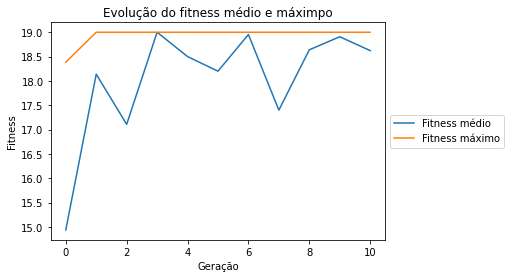

In [11]:
bag = KnapsackProblem(
        obj=objs,
        capacity=MAX_CAPACITY,
        num_population=10,
        max_gen_to_converge=10,
        penalty=1
    )
bag.solve(
        False,
        0.1
    )

bag.plot()

### N = 10 e MAX = 50

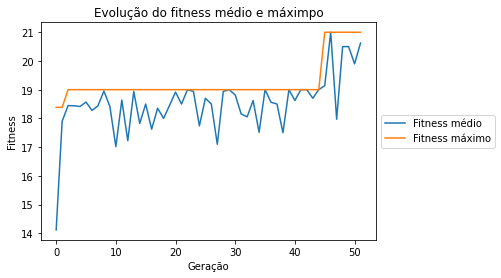

In [13]:
bag = KnapsackProblem(
        obj=objs,
        capacity=MAX_CAPACITY,
        num_population=10,
        max_gen_to_converge=50,
        penalty=1
    )
bag.solve(
        False,
        0.1
    )

bag.plot()

### N = 10 e MAX = 100

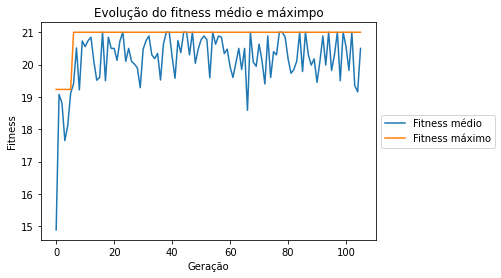

In [16]:
bag = KnapsackProblem(
        obj=objs,
        capacity=MAX_CAPACITY,
        num_population=10,
        max_gen_to_converge=100,
        penalty=1
    )
bag.solve(
        False,
        0.1
    )

bag.plot()

### N = 50 e MAX = 10

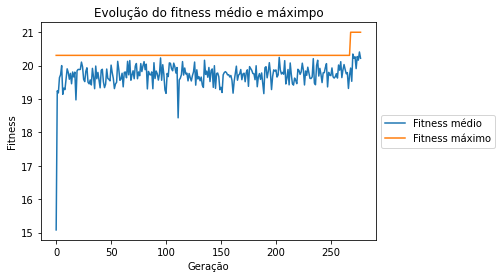

In [17]:
bag = KnapsackProblem(
        obj=objs,
        capacity=MAX_CAPACITY,
        num_population=50,
        max_gen_to_converge=10,
        penalty=1
    )
bag.solve(
        False,
        0.1
    )

bag.plot()

### N = 10 e MAX = 50

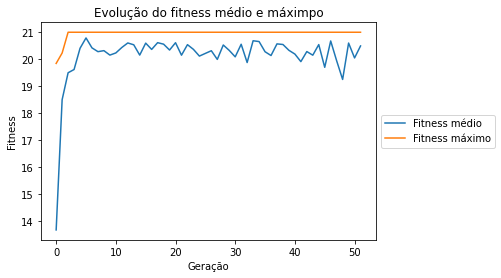

In [19]:
bag = KnapsackProblem(
        obj=objs,
        capacity=MAX_CAPACITY,
        num_population=50,
        max_gen_to_converge=50,
        penalty=1
    )
bag.solve(
        False,
        0.1
    )

bag.plot()

### N = 50 e MAX = 100

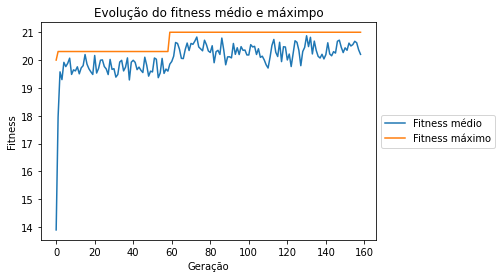

In [20]:
bag = KnapsackProblem(
        obj=objs,
        capacity=MAX_CAPACITY,
        num_population=50,
        max_gen_to_converge=100,
        penalty=1
    )
bag.solve(
        False,
        0.1
    )

bag.plot()

### N = 100 e MAX = 10

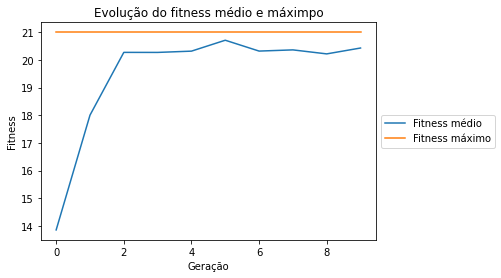

In [22]:
bag = KnapsackProblem(
        obj=objs,
        capacity=MAX_CAPACITY,
        num_population=100,
        max_gen_to_converge=10,
        penalty=1
    )
bag.solve(
        False,
        0.1
    )

bag.plot()

### N = 100 e MAX = 50

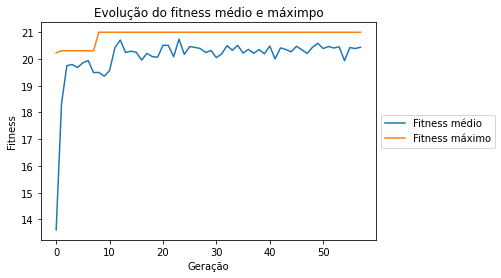

In [23]:
bag = KnapsackProblem(
        obj=objs,
        capacity=MAX_CAPACITY,
        num_population=100,
        max_gen_to_converge=50,
        penalty=1
    )
bag.solve(
        False,
        0.1
    )

bag.plot()

### N = 100 e MAX = 100

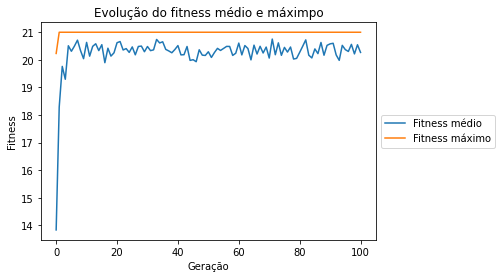

In [24]:
bag = KnapsackProblem(
        obj=objs,
        capacity=MAX_CAPACITY,
        num_population=100,
        max_gen_to_converge=100,
        penalty=1
    )
bag.solve(
        False,
        0.1
    )

bag.plot()


##### O próximo teste consiste em variar o valor da proporção de piores que são jogados fora

### N = 100 e proportion = 0.1

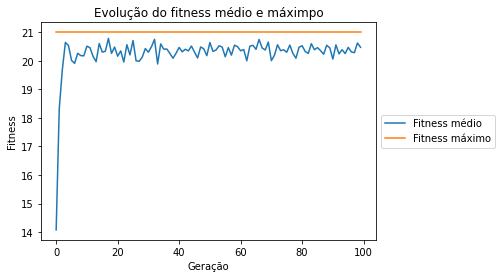

In [30]:
bag = KnapsackProblem(
        obj=objs,
        capacity=MAX_CAPACITY,
        num_population=100,
        max_gen_to_converge=100,
        penalty=1
    )
bag.solve(
        False,
        0.1
    )

bag.plot()

### N = 100 e proportion = 0.2

In [ ]:
bag = KnapsackProblem(
        obj=objs,
        capacity=MAX_CAPACITY,
        num_population=100,
        max_gen_to_converge=100,
        penalty=1
    )
bag.solve(
        False,
        0.2
    )

bag.plot()

### N = 100 e proportion = 0.5

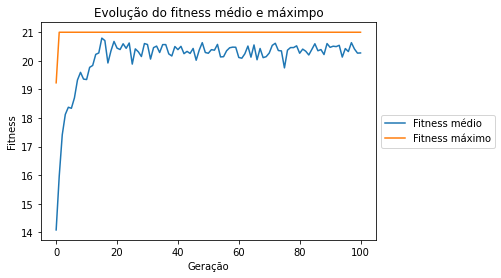

In [46]:
bag = KnapsackProblem(
        obj=objs,
        capacity=MAX_CAPACITY,
        num_population=100,
        max_gen_to_converge=100,
        penalty=1
    )
bag.solve(
        False,
        0.5
    )

bag.plot()

### N = 100 e proportion = 0.2

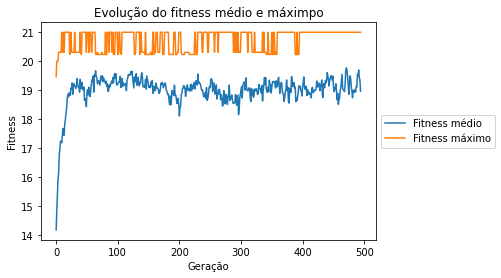

In [33]:
bag = KnapsackProblem(
        obj=objs,
        capacity=MAX_CAPACITY,
        num_population=100,
        max_gen_to_converge=100,
        penalty=1
    )
bag.solve(
        False,
        0.9
    )

bag.plot()